# Growth rates - Brazilian states

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from matplotlib.dates import DateFormatter

## Data

### COVID-19 DATA

Data source: [Brasil.IO](https://brasil.io/dataset/covid19/caso).

Download updated data:

In [2]:
url = "https://brasil.io/dataset/covid19/caso/?format=csv"
filename = 'data/brazil_' + url.split("/")[-3] + '.csv'
with open(filename, "wb") as f:
    r = requests.get(url)
    f.write(r.content)

Or load a local file until a specific date:

In [2]:
filename = 'data/brazil_covid19_06_08.csv'

In [3]:
df = pd.read_csv(filename)
df.head()

date state          city place_type  confirmed  deaths  is_last  \
0  2020-06-08    AC    Acrelândia       city        166       2     True   
1  2020-06-08    AC  Assis Brasil       city         60       4     True   
2  2020-06-08    AC     Brasiléia       city        128       5     True   
3  2020-06-08    AC        Bujari       city         77       1     True   
4  2020-06-08    AC      Capixaba       city         65       1     True   

   estimated_population_2019  city_ibge_code  confirmed_per_100k_inhabitants  \
0                    15256.0       1200013.0                      1088.09649   
1                     7417.0       1200054.0                       808.95241   
2                    26278.0       1200104.0                       487.09947   
3                    10266.0       1200138.0                       750.04870   
4                    11733.0       1200179.0                       553.99301   

   death_rate  
0      0.0120  
1      0.0667  
2      0.0391  
3      0.0130  
4      0.0154

In [4]:
df2 = df[ df['place_type'] == 'state']
#df3 = df2.dropna()
df2['city_ibge_code'] = df2['city_ibge_code'].astype(int)
df3 = df2.drop(columns= ['city'])

Growh rate raw calculation:

In [5]:
def delta(df_conf):

    list_ = []
    list_.append(0)

    for j in range(len(df_conf) - 1):

        list_.append(df_conf[j+1] - df_conf[j])

    return list_

Select a list of states:

In [6]:
# All
states_ = df3['state'].unique()

# Specify
#states_ = np.array(['SP', 'RJ'])

AC


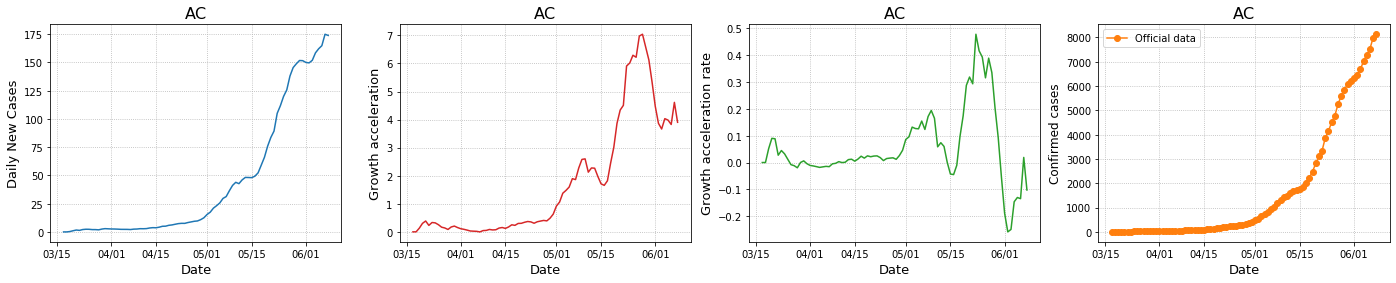

AL


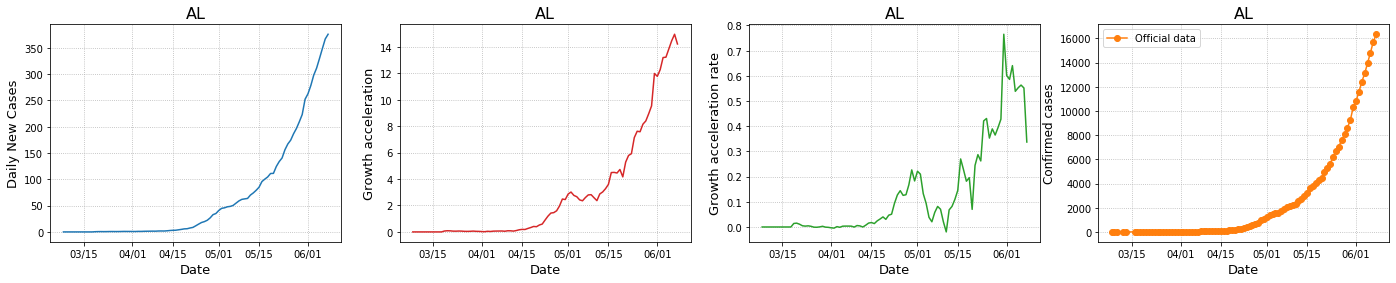

AP


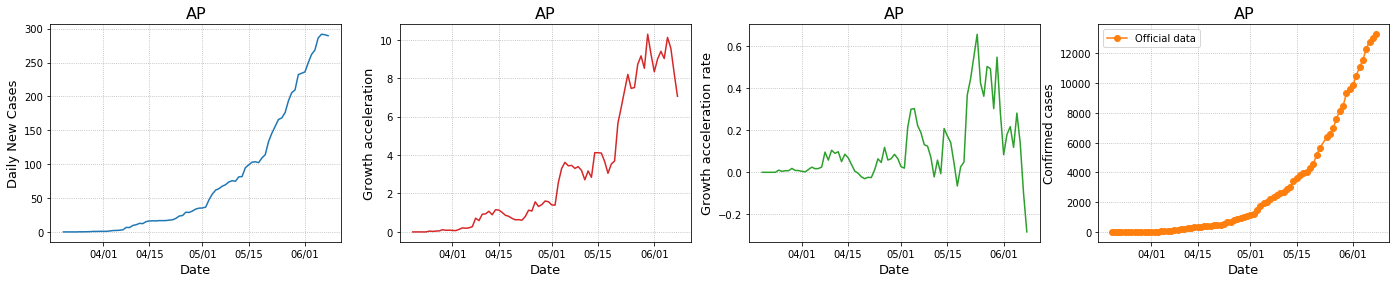

BA


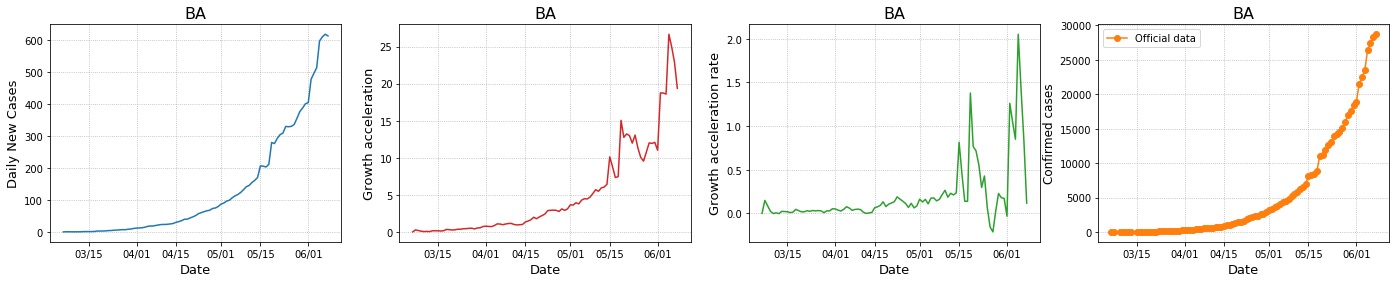

CE


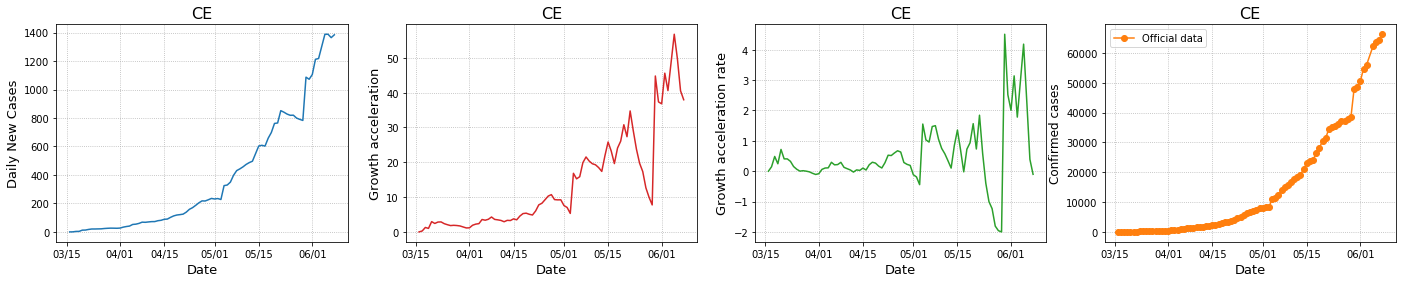

DF


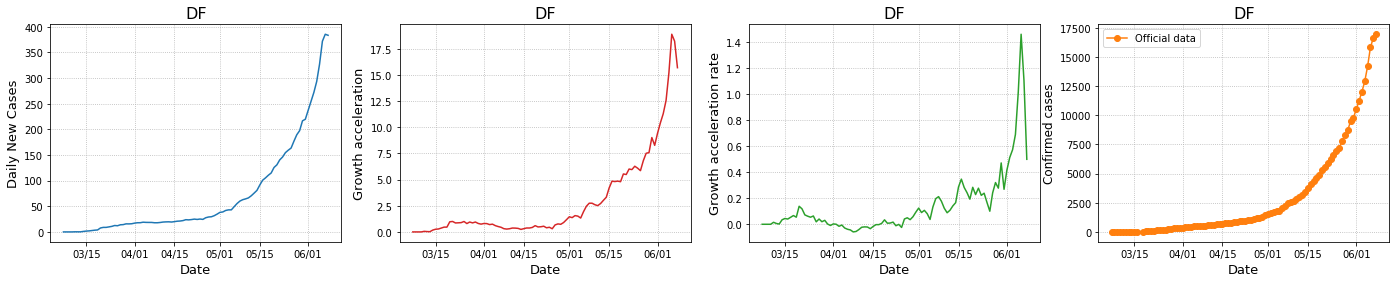

ES


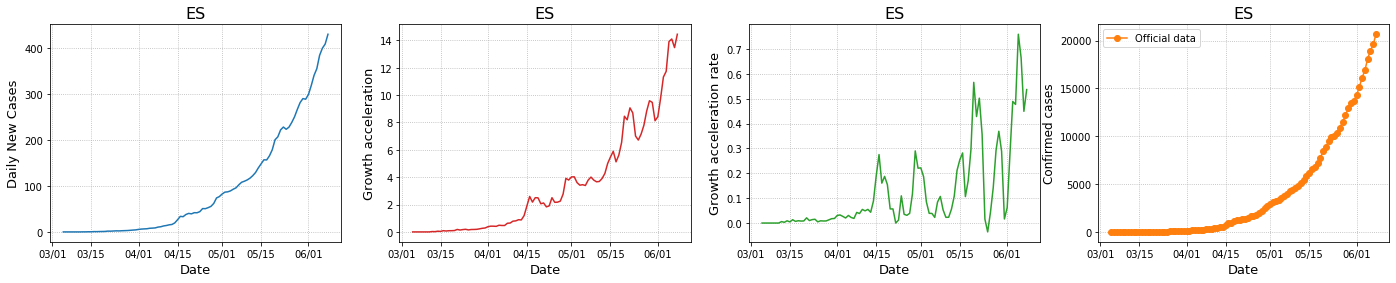

GO


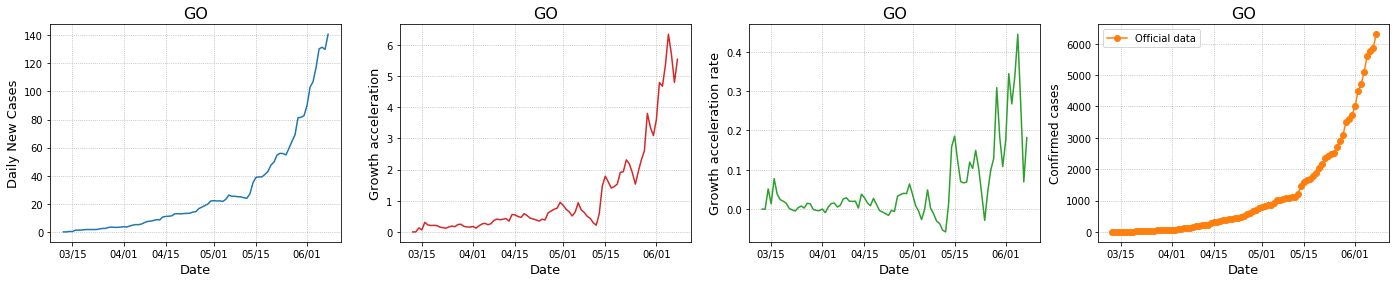

MA


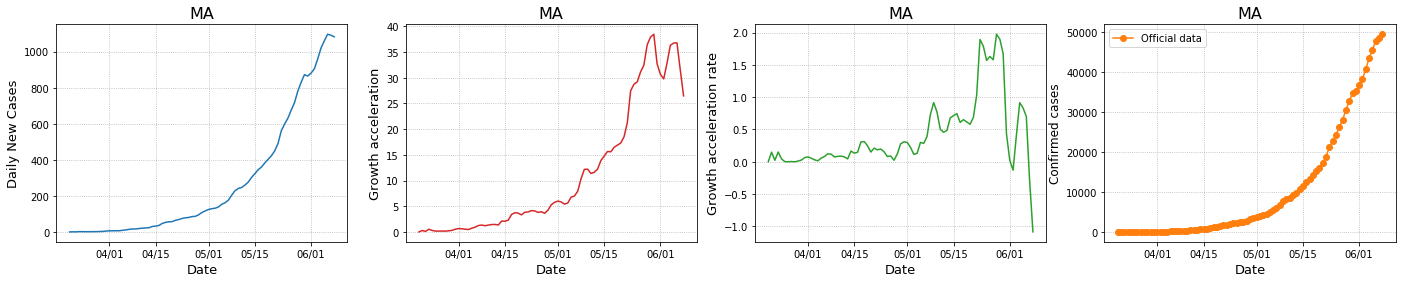

MG


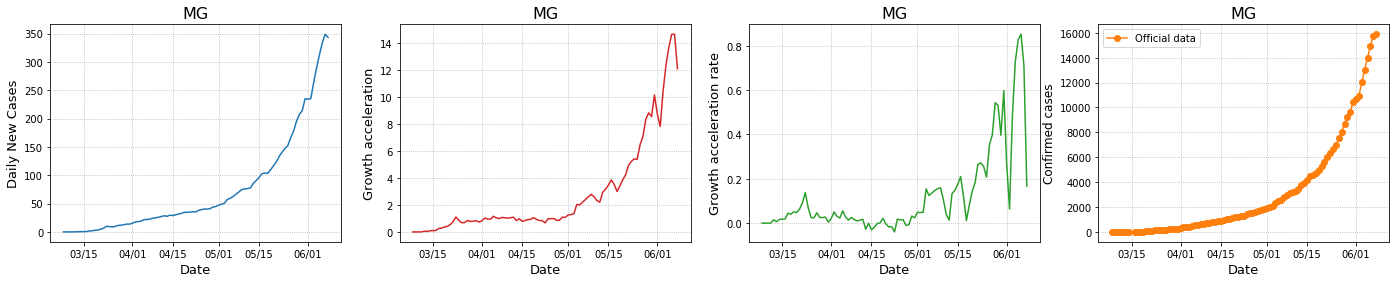

MT


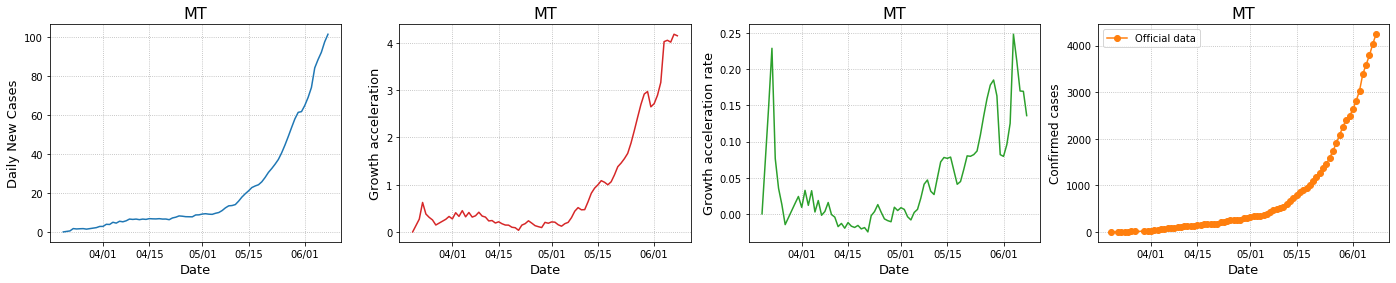

PA


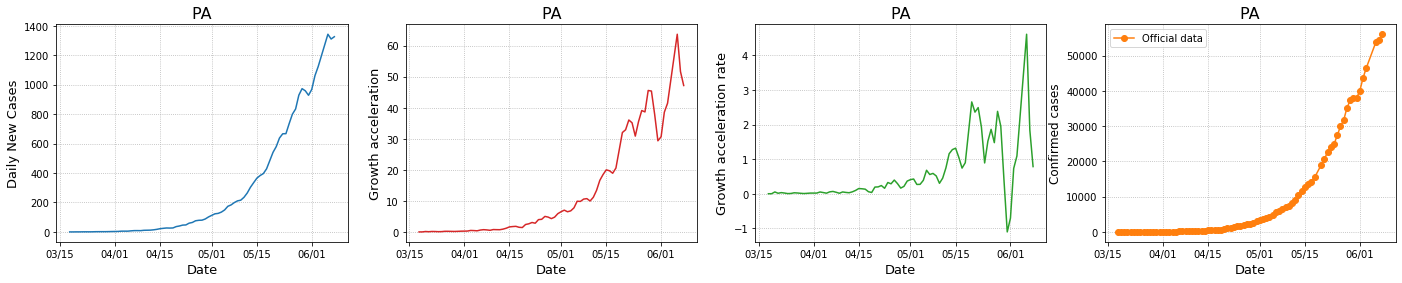

PB


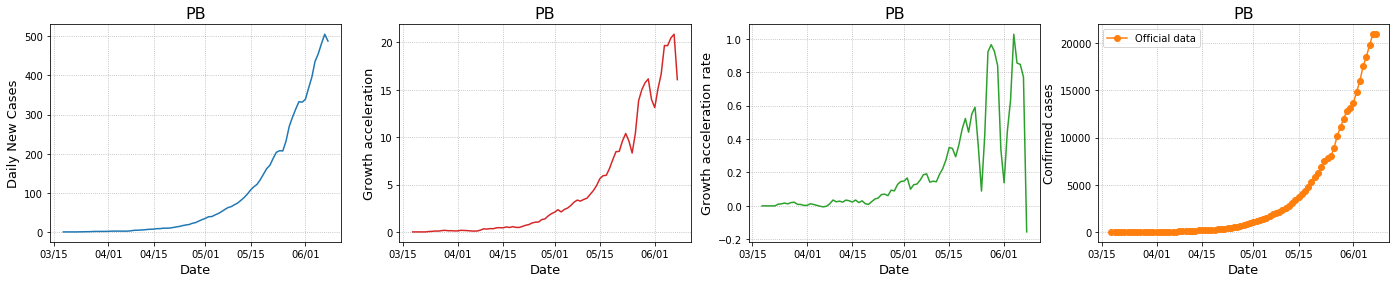

PI


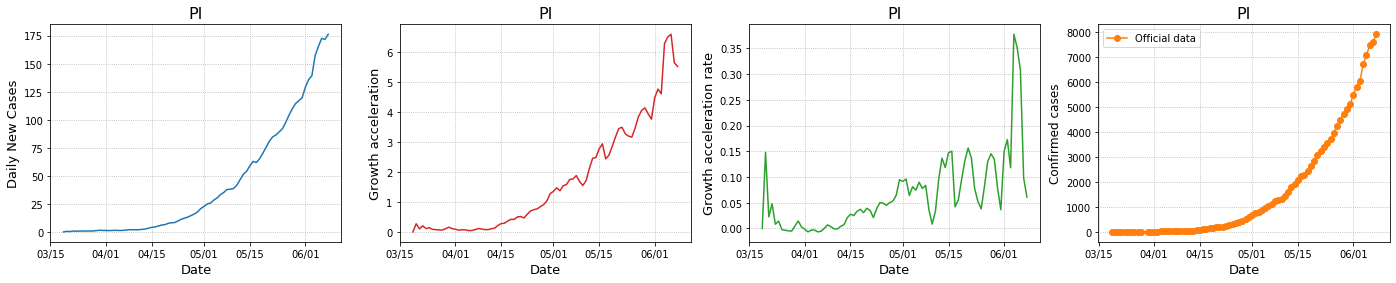

PR


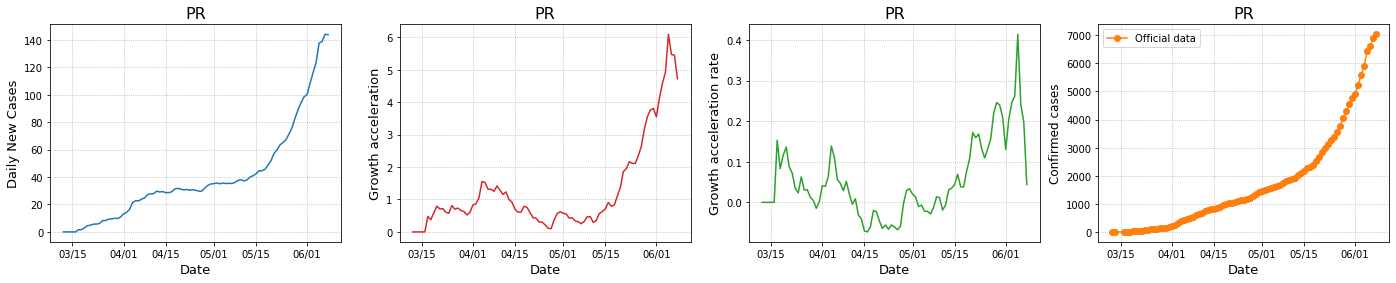

RJ


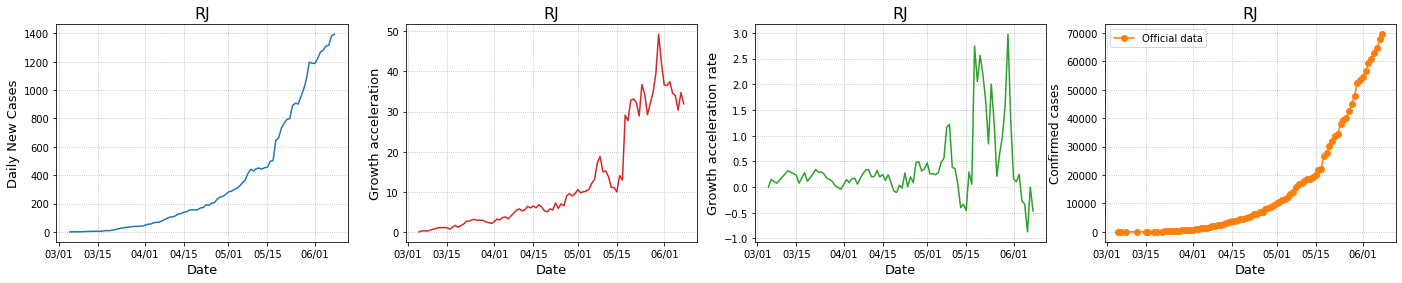

RO


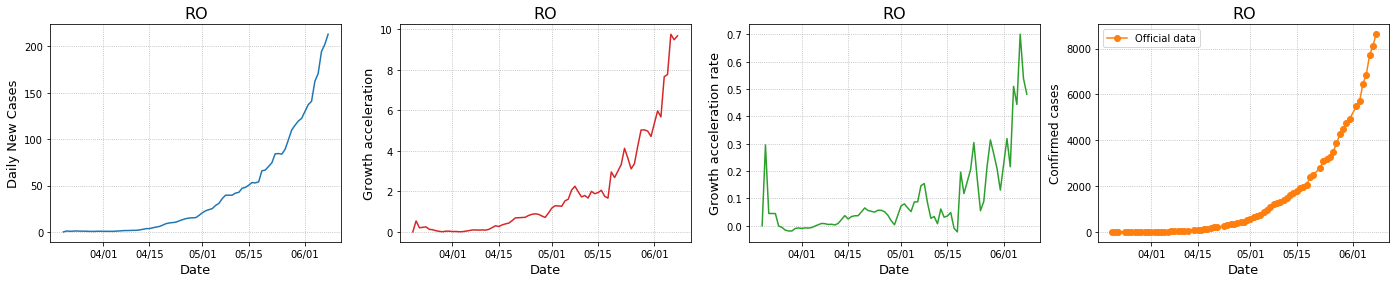

RS


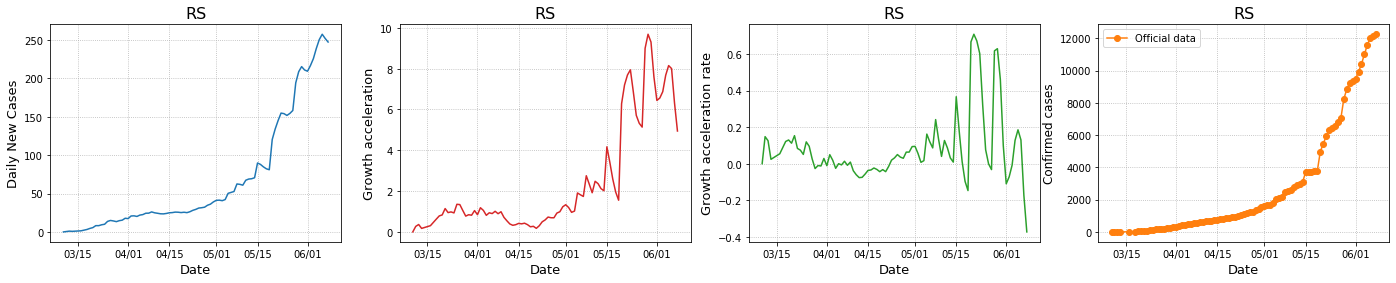

SC


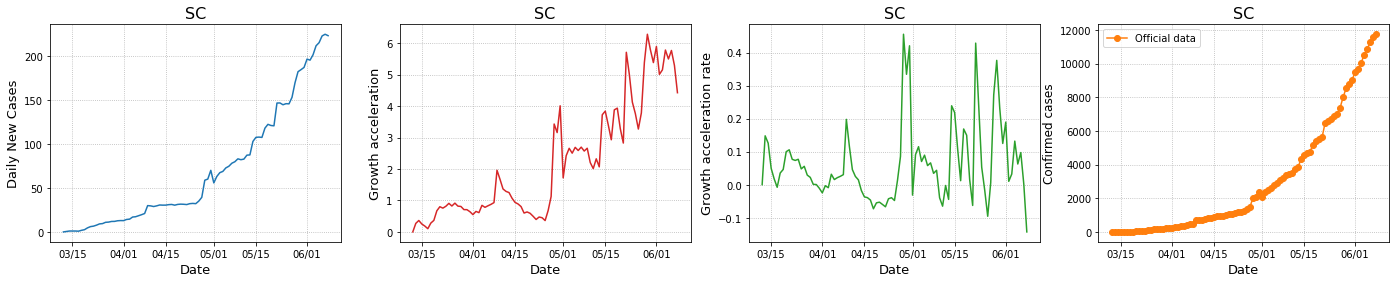

SP


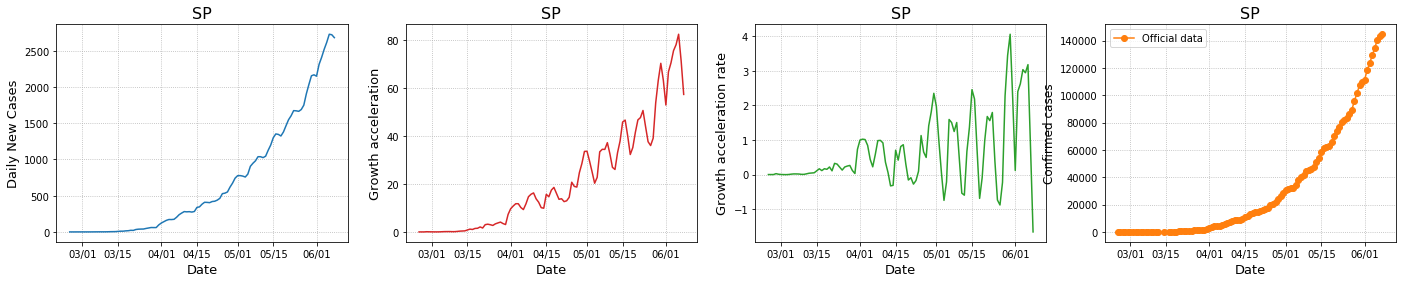

TO


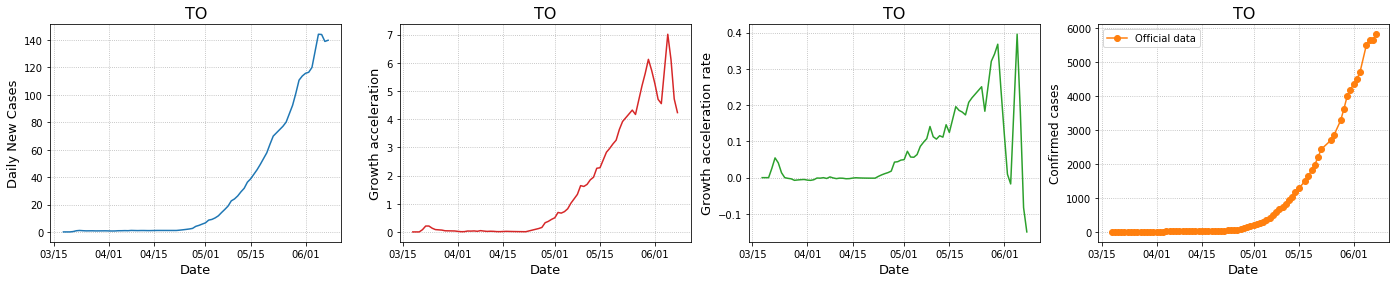

AM


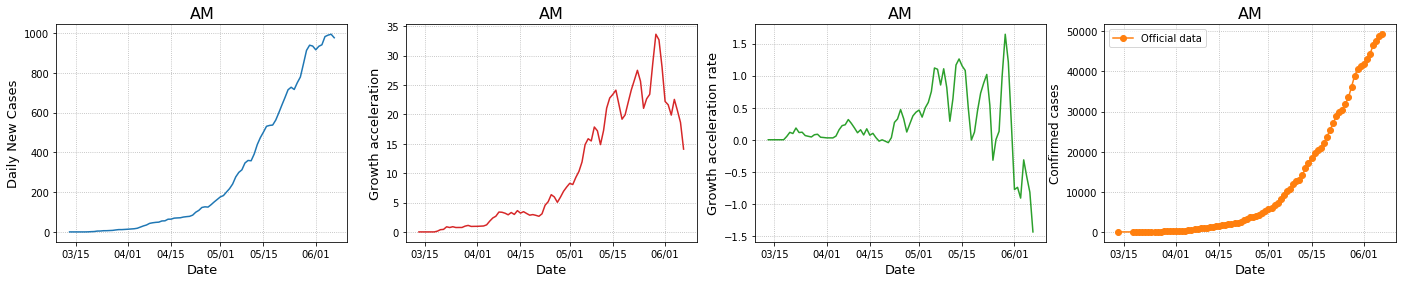

MS


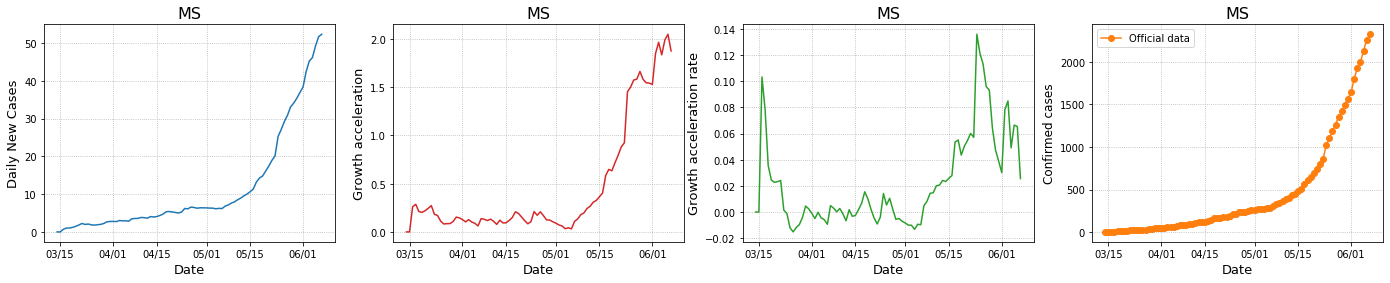

PE


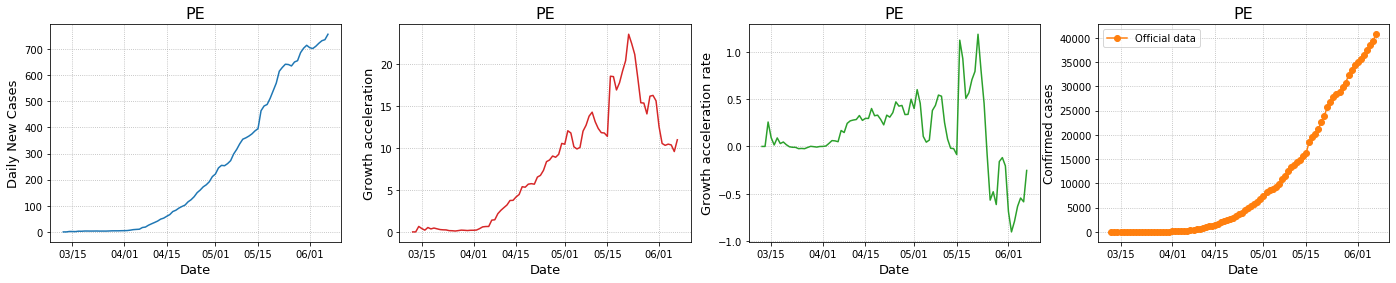

RR


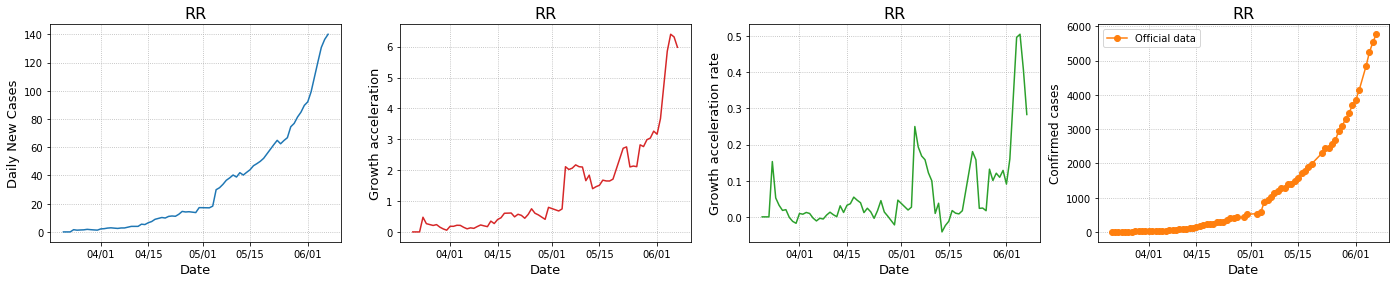

SE


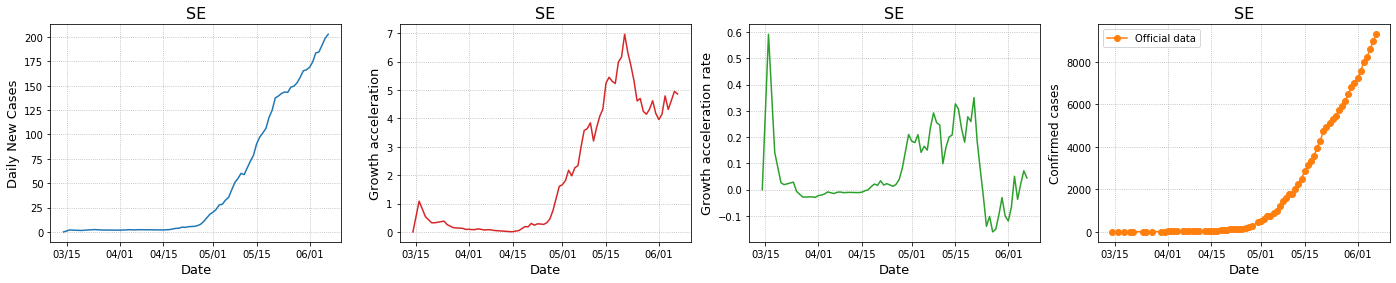

RN


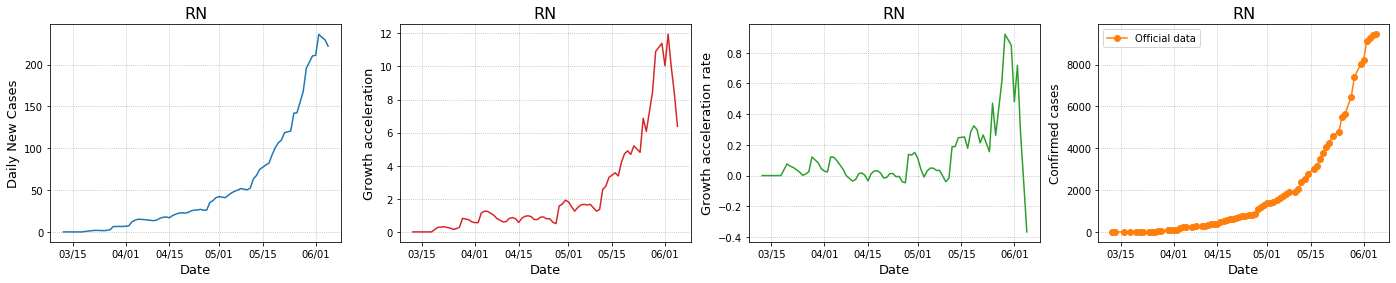

In [7]:
results_ = []

### EWM
alpha = 30.
alpha2 = 7.
alpha3 = 5.

### Classification threshold
# Cases
CASES_threshold = 50
# Normalized growth rate (%)
GROWTH_RATE_threshold = 1
# Normalized growth acceleration (%)
GROWTH_ACCEL_threshold = 0.01

### Last date into results_ list?
last = True
### If not, what date? (Do no forget to set last = False)
#### CAREFUL: a location might not have data for this particular day (some places do not have records on sundays, for instance)
#until_date = '2020-05-02'

for states in states_:

    print(states)

    df_ = df3[ df3['state'] == states].sort_values(by='date').set_index('date')
    df_ =  df_ [ df_['confirmed']  > 0]
    df_.index = pd.to_datetime(df_.index)

    # Rate
    df_['growth_rate_'] = delta(df_['confirmed'])

    # Exponential weight
    df_['growth_rate'] = df_['growth_rate_'].ewm(com= alpha).mean()

    # Rate
    df_['growth_accel_'] = delta(df_['growth_rate'])

    # Exponential weight
    df_['growth_accel'] = df_['growth_accel_'].ewm(com= alpha2).mean()

    # Rate
    df_['growth_accel_rate_'] = delta(df_['growth_accel'])

    # Exponential weight
    df_['growth_accel_rate'] = df_['growth_accel_rate_'].ewm(com= alpha3).mean()

    # Dropping unsmoothed quantities
    df_ = df_.drop('growth_rate_', axis=1)
    df_ = df_.drop('growth_accel_', axis=1)
    df_ = df_.drop('growth_accel_rate_', axis=1)

    # Normalized quantities
    df_['growth_rate_NORM_(%)'] = 100*df_['growth_rate'] / df_['confirmed']
    df_['growth_accel_NORM_(%)'] = 100*df_['growth_accel'] / df_['confirmed']
    df_['growth_accel_rate_NORM_(%)'] = 100*df_['growth_accel_rate'] / df_['confirmed']

    # Classification

    df_['LENTO'] =  (df_['confirmed'] < CASES_threshold)*1

    df_['EXPONENCIAL'] = ( df_['growth_accel_NORM_(%)']  >= GROWTH_ACCEL_threshold )*1

    df_['DESACELERACAO'] = ( df_['growth_accel_NORM_(%)']  <= -GROWTH_ACCEL_threshold )*1

    df_['ESTAVEL'] = ( (df_['growth_rate_NORM_(%)']  <  GROWTH_RATE_threshold) &  (df_['growth_accel_NORM_(%)']  > - GROWTH_ACCEL_threshold) & (df_['growth_accel_NORM_(%)']  <         GROWTH_ACCEL_threshold) )*1

    df_['LINEAR'] = ( (df_['growth_rate_NORM_(%)']  >=  GROWTH_RATE_threshold ) &  (df_['growth_accel_NORM_(%)']  > - GROWTH_ACCEL_threshold) & (df_['growth_accel_NORM_(%)']  < GROWTH_ACCEL_threshold) )*1


    df_.loc[df_['LENTO'] == True, 'CLASSIFICACAO'] = 'LENTO'
    df_.loc[ (df_['LENTO'] != True) & (df_['DESACELERACAO'] == True), 'CLASSIFICACAO'] = 'DESACELERACAO'
    df_.loc[ (df_['LENTO'] != True) & (df_['ESTAVEL'] == True), 'CLASSIFICACAO'] = 'ESTAVEL'
    df_.loc[ (df_['LENTO'] != True) & (df_['LINEAR'] == True), 'CLASSIFICACAO' ] = 'LINEAR'
    df_.loc[ (df_['LENTO'] != True) & (df_['EXPONENCIAL'] == True), 'CLASSIFICACAO' ] = 'EXPONENCIAL'

    # Plot
    fig, axes = plt.subplots(1, 4, figsize= (24, 4))
    
        
    axes[0].plot(df_['growth_rate'])
    axes[0].set_title(states, fontsize= 16)
    axes[0].set_ylabel('Daily New Cases', fontsize= 13)
    axes[0].set_xlabel('Date', fontsize= 13)
    axes[0].grid(linestyle=':')

    axes[1].plot(df_['growth_accel'], color= 'C3')
    axes[1].set_title(states, fontsize= 16)
    axes[1].set_ylabel('Growth acceleration', fontsize= 13)
    axes[1].set_xlabel('Date', fontsize= 13)
    axes[1].grid(linestyle=':')

    axes[2].plot(df_['growth_accel_rate'], color= 'C2')
    axes[2].set_title(states, fontsize= 16)
    axes[2].set_ylabel('Growth acceleration rate', fontsize= 13)
    axes[2].set_xlabel('Date', fontsize= 13)
    axes[2].grid(linestyle=':')

    axes[3].plot(df_[['confirmed']], 'o-', color= 'C1', label= 'Official data')
    axes[3].set_ylabel('Confirmed cases', fontsize= 12)
    axes[3].set_title(states, fontsize= 16)
    axes[3].set_xlabel('Date', fontsize= 13)
    axes[3].grid(linestyle=':')
    axes[3].legend()


    date_form = DateFormatter("%m/%d")
    axes[0].xaxis.set_major_formatter(date_form)
    axes[1].xaxis.set_major_formatter(date_form)
    axes[2].xaxis.set_major_formatter(date_form)
    axes[3].xaxis.set_major_formatter(date_form)

    df_ = df_.reset_index()

    if last:
        results_.append(df_.iloc[-1].to_dict())
    else:
        idx_ = df_.index[df_['date'] == until_date]
        if len(idx_) > 0:
            results_.append(df_.iloc[idx_[0]].to_dict())
        else:
            print('%s data NOT available for %s' % (until_date, states))

    #plt.savefig('file_name.png', bbox_inches='tight')
    plt.show()


results = pd.DataFrame(results_)

#results.to_csv('results/dfs/growth_states_BR_class_.csv', index= True, sep= ';')